In [ ]:
from google.colab import files
uploaded=files.upload()

Saving facereact.zip to facereact.zip


In [ ]:
import zipfile
import os

zip_path='/content/facereact.zip'

extract_name='/content/face_dataset'
with zipfile.ZipFile(zip_path,'r') as zep_ref:
  zep_ref.extractall(extract_name)

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,Activation,MaxPooling2D,Input,GlobalMaxPooling2D,SeparableConv2D,Dropout,BatchNormalization,Flatten
from tensorflow.keras.applications import ResNet50,EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard
from collections import Counter
from ultralytics import YOLO
import cv2 as cv

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
path_train='/content/face_dataset/train'
path_test='/content/face_dataset/test'
img_size=48
batch=32
train,val=tf.keras.utils.image_dataset_from_directory(path_train,batch_size=batch,image_size=(img_size,img_size),validation_split=0.2,subset='both',seed=42,color_mode='grayscale')
test=tf.keras.utils.image_dataset_from_directory(path_test,batch_size=batch,image_size=(img_size,img_size),seed=42,shuffle=False,color_mode='grayscale')

Found 25102 files belonging to 5 classes.
Using 20082 files for training.
Using 5020 files for validation.
Found 6236 files belonging to 5 classes.


In [ ]:
class_names=train.class_names
class_names

['angry', 'fear', 'happy', 'neutral', 'sad']

In [ ]:
augment = tf.keras.Sequential([

    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),

    ])

In [ ]:

counter = Counter()
for images, labels in train:

    counter.update(labels.numpy())

for i, cls in enumerate(class_names):
    print(f"Class {cls}: {counter[i]} images")

Class angry: 3212 images
Class fear: 3287 images
Class happy: 5813 images
Class neutral: 3961 images
Class sad: 3809 images


In [ ]:
labels = []
for _, batch_labels in train:
    labels.extend(batch_labels.numpy())
labels = np.array(labels)
classes = np.unique(labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=labels
)
class_weights = dict(zip(classes, class_weights))
print("Class weights:", class_weights)

Class weights: {np.int32(0): np.float64(1.2504358655043586), np.int32(1): np.float64(1.2219044721630665), np.int32(2): np.float64(0.6909341131945639), np.int32(3): np.float64(1.0139863670790203), np.int32(4): np.float64(1.0544499868731951)}


In [ ]:
def preprocessing(image, label):

    image = tf.cast(image, tf.float32) / 255.0

    return image, label


In [ ]:
train=train.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val=val.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test=test.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

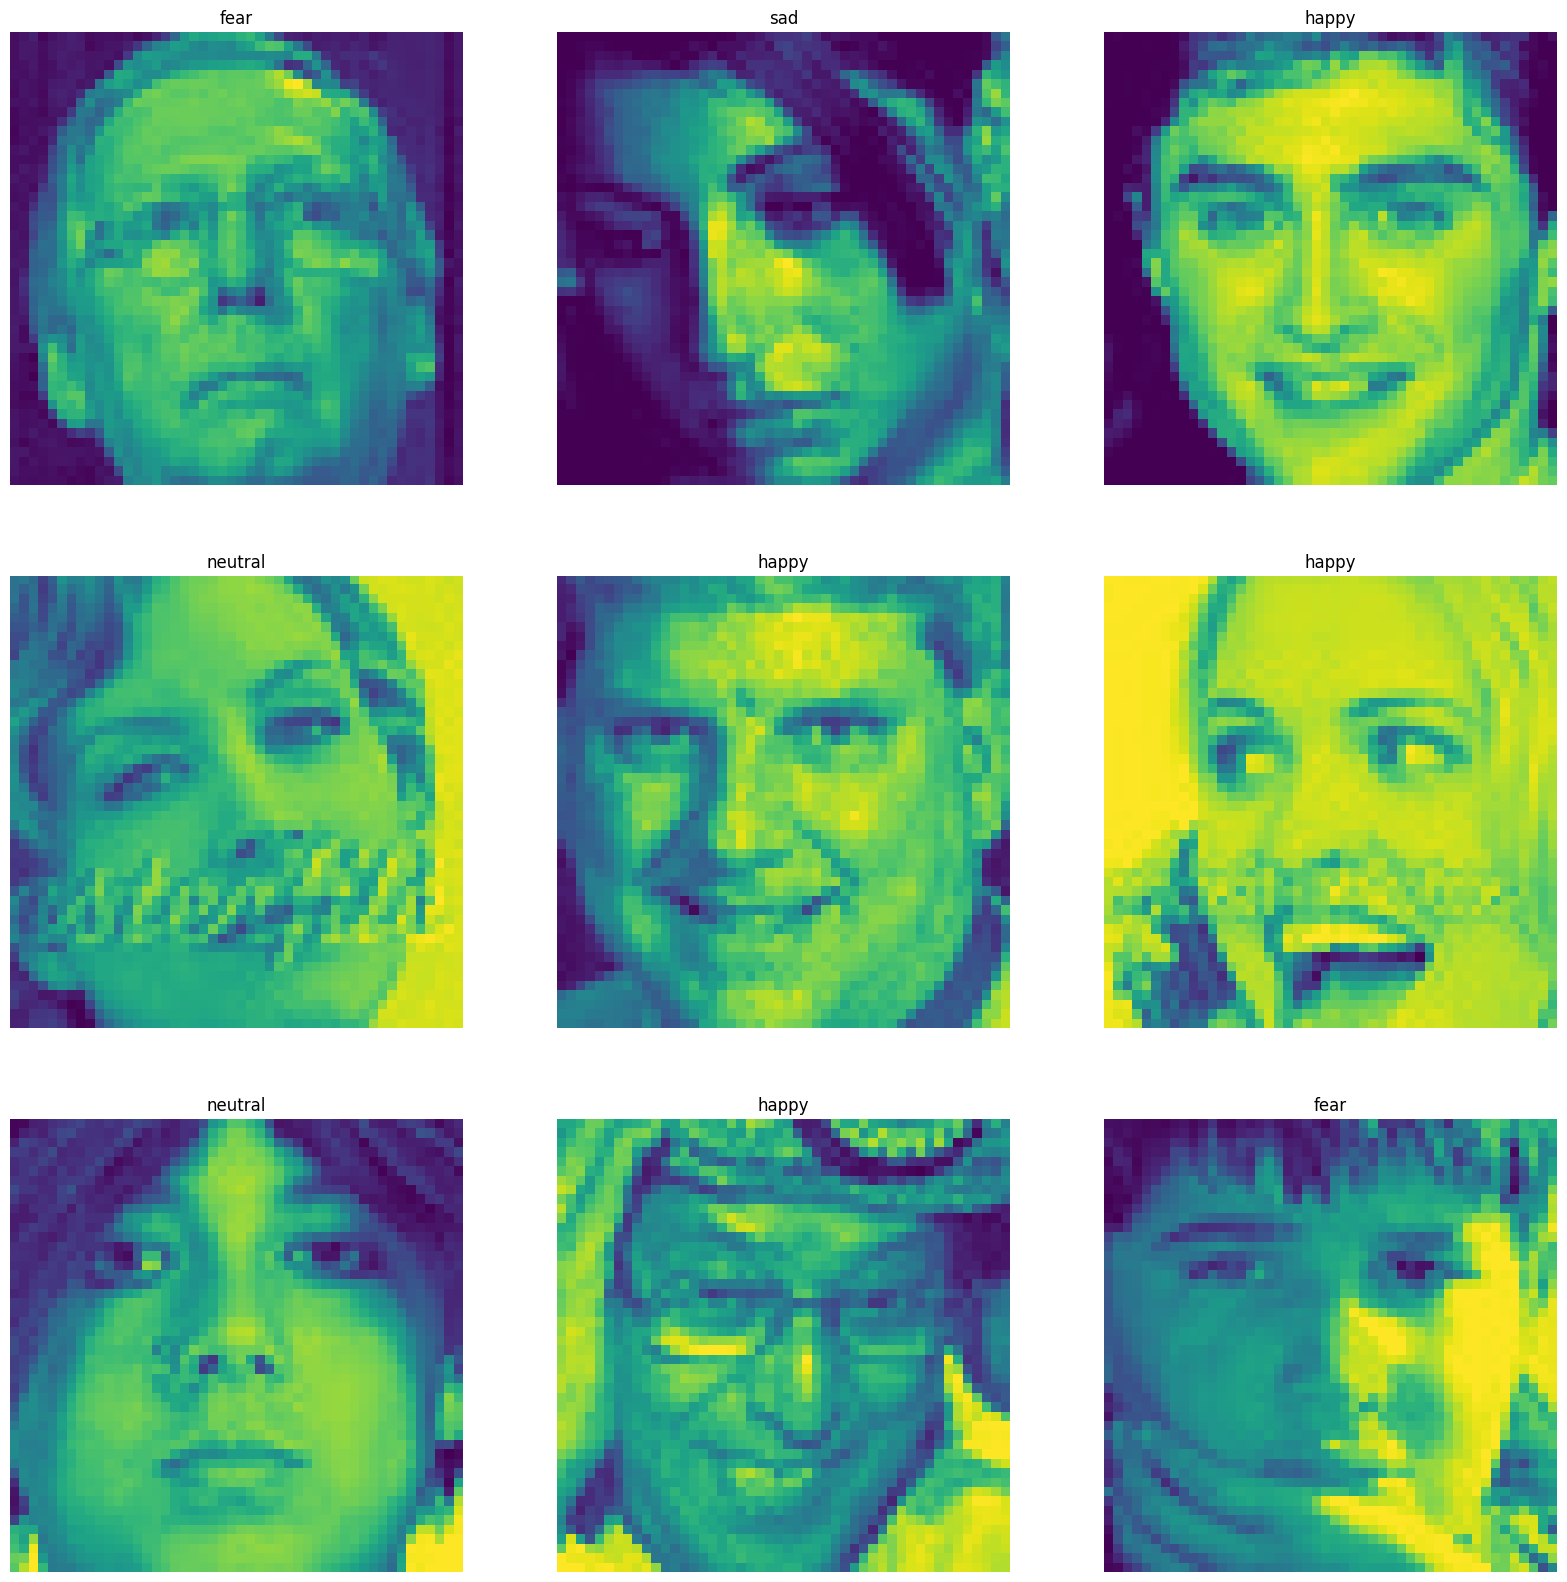

In [ ]:
for image,label in train.take(1):
  plt.figure(figsize=(20,20))
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    plt.title(class_names[label[i]])
    plt.axis('off')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
earlystop=EarlyStopping(verbose=1,patience=4)
red=ReduceLROnPlateau(patience=4)
checkpoint=ModelCheckpoint('/content/drive/MyDrive/bestface_model.keras',verbose=1,save_best_only=True)
tnsbord=TensorBoard(histogram_freq=1)
callbacks = [earlystop, red, checkpoint, tnsbord]

In [ ]:
def repeat_channels(x):
    return tf.repeat(x, repeats=3, axis=-1)

inputs = Input(shape=(48,48,1))
x = augment(inputs)
x=tf.keras.layers.Lambda(repeat_channels)(x)
base = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
for layer in base.layers:
    layer.trainable = False
x = base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = tf.keras.models.Model(inputs, outputs)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train,validation_data=val,epochs=10,class_weight=class_weights,callbacks=callbacks)

Epoch 1/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2076 - loss: 1.6700
Epoch 1: val_loss improved from inf to 1.60842, saving model to /content/drive/MyDrive/bestface_model.keras
628/628 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.2076 - loss: 1.6700 - val_accuracy: 0.1799 - val_loss: 1.6084 - learning_rate: 0.0010
Epoch 2/10
627/628 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2052 - loss: 1.6119
Epoch 2: val_loss did not improve from 1.60842
628/628 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.2053 - loss: 1.6119 - val_accuracy: 0.2468 - val_loss: 1.6099 - learning_rate: 0.0010
Epoch 3/10
627/628 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2203 - loss: 1.6105
Epoch 3: val_loss did not improve from 1.60842
628/628 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - accuracy: 0.2203 - loss: 1.6105 - val_accuracy: 0.2157 - val_loss: 1.6091 - learning_rate: 0.0010
Epoch 4/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2410 - loss: 1.6072
Epoch 4: val_loss imp

In [ ]:
# lets try efficientnetb0

inputs = Input(shape=(48,48,1))
x = augment(inputs)
x=x=tf.keras.layers.Lambda(repeat_channels)(x)
base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=x)
for layer in base.layers:
    layer.trainable = False
x = base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(class_names), activation='softmax')(x)

eff_model = tf.keras.models.Model(inputs, outputs)

eff_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
eff_model.fit(train,validation_data=val,epochs=10,class_weight=class_weights,callbacks=callbacks)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1886 - loss: 1.6312
Epoch 1: val_loss did not improve from 1.60467
628/628 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.1886 - loss: 1.6312 - val_accuracy: 0.1614 - val_loss: 1.6104 - learning_rate: 0.0010
Epoch 2/10
626/628 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1769 - loss: 1.6104
Epoch 2: val_loss did not improve from 1.60467
628/628 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.1770 - loss: 1.6104 - val_accuracy: 0.1614 - val_loss: 1.6100 - learning_rate: 0.0010
Epoch 3/10
626/628 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1816 - loss: 1.6099
Epoch 3: val_loss did not improve from 1.60467
628/628 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.1817 - loss: 1.6099 - val_accuracy: 0.1614 - val_loss: 1.6100 - learning_rate: 0.0010
Epoch 4/10
626/628 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1841 - loss: 1.6099
Epoch 4: val_loss did not impro

In [ ]:
def create_mini_xception(input_shape=(48,48,1),num_classes=5):
  model=tf.keras.Sequential()
  model.add(Input(shape=input_shape))

  model.add(Conv2D(8,(3,3),padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(SeparableConv2D(16,(3,3),padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(SeparableConv2D(32,(3,3),padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(SeparableConv2D(32, (3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(SeparableConv2D(64,(3,3),padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(SeparableConv2D(64, (3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  return model

In [ ]:
min_model=create_mini_xception()
min_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
min_model.fit(train,validation_data=val,epochs=60,class_weight=class_weights,callbacks=callbacks)

Epoch 1/60
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2401 - loss: 1.8781
Epoch 1: val_loss improved from 1.60467 to 1.54510, saving model to /content/drive/MyDrive/bestface_model.keras
628/628 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.2402 - loss: 1.8778 - val_accuracy: 0.3022 - val_loss: 1.5451 - learning_rate: 0.0010
Epoch 2/60
624/628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3338 - loss: 1.5482
Epoch 2: val_loss improved from 1.54510 to 1.41448, saving model to /content/drive/MyDrive/bestface_model.keras
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3339 - loss: 1.5480 - val_accuracy: 0.3930 - val_loss: 1.4145 - learning_rate: 0.0010
Epoch 3/60
621/628 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4002 - loss: 1.4449
Epoch 3: val_loss improved from 1.41448 to 1.35890, saving model to /content/drive/MyDrive/bestface_model.keras
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4004 - loss: 1.4447 - val_accuracy: 0.4279 - val_loss: 1.3589 - 

In [ ]:
min_model.evaluate(test)

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5810 - loss: 1.0719


[1.0480420589447021, 0.5881975889205933]

In [ ]:
model.save('/content/drive/MyDrive/emotion_model.keras')

In [3]:
import tensorflow as tf
import sys
print(f"TensorFlow: {tf.__version__}")
print(f"Python: {sys.version}")

TensorFlow: 2.19.0
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


=== معلومات الإصدارات ===
TensorFlow: 2.19.0
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
System: Linux 6.1.123+
Processor: x86_64
